In [25]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution 
%matplotlib inline

In [2]:
dfs = [
        pd.read_excel("./data/K-1_MI.xlsx", sheet_name="d2", verbose=True, na_values=[" Bad Data","Bad Data"]),
        pd.read_excel("./data/K-1_MI.xlsx", sheet_name="d3", verbose=True, na_values=[" Bad Data","Bad Data"]),
        pd.read_excel("./data/K-1_MI.xlsx", sheet_name="d5", verbose=True, na_values=[" Bad Data","Bad Data"]),
        pd.read_excel("./data/K-1_MI.xlsx", sheet_name="d6", verbose=True, na_values=[" Bad Data","Bad Data"])
]

for i in range(len(dfs)):
    dfs[i] = dfs[i].interpolate()

Reading sheet d2
Reading sheet d3
Reading sheet d5
Reading sheet d6


In [3]:
frequencies = list()
for df in dfs:
    frequencies.append(pd.infer_freq(df["date"]))
freqs = pd.DataFrame(data=frequencies, columns=["freq"])
print(freqs)

  freq
0  10S
1  10S
2  10S
3   2S


In [4]:
dfs[3] = dfs[3].iloc[::5, :]

In [5]:
for i in range(len(dfs)):
    print(dfs[i]["LT01"].mean(), dfs[i]["LT01"].std())
print("---")
for i in range(len(dfs)):
    print(dfs[i]["DP"].mean(), dfs[i]["DP"].std())

14.323826126126127 7.20651365510192
14.976894794794795 5.745944301643387
15.153623123123122 9.836713911679873
15.395241999999998 5.397807676119805
---
-0.11744454454454455 0.020880926558840225
-0.06990950950950951 0.013091477886249205
-0.11810740740740741 0.016163895825006686
-0.09423500000000001 0.019835653271407967


In [6]:
allData = dfs[0].append(dfs[1]).append(dfs[2]).append(dfs[3])
allData.head()

,date,FP05,LT1,LT2,LT3,LT4,TMA,TMB,TMC,TMD,...,PTWS,TW02,TW01,FW03,TW04,TW03,FW04,TTWT,PTWT,PPW
0,7/06/2014 15:30:10.0,1068.9575,21.4107,11.6199,11.714,18.8643,43.8947,76.1302,75.8843,74.866,...,19.3311,539.8597,301.2129,9.4894,539.5955,290.8920,14.2998,177.7786,10.3202,3.5039
1,7/06/2014 15:30:20.0,1068.9575,21.4107,11.6199,11.714,18.8643,43.8947,76.1302,75.8843,74.866,...,19.3311,539.8597,301.2129,9.4894,539.5955,290.8920,14.2998,177.7786,10.3202,3.5039
2,7/06/2014 15:30:30.0,1068.9575,21.4107,11.6199,11.714,18.8643,43.8947,76.1302,75.8843,74.866,...,19.3147,539.8597,301.2129,9.4894,539.5955,292.1826,14.2998,177.7786,10.3202,3.4937
3,7/06/2014 15:30:40.0,1068.9575,21.4107,11.6199,11.714,18.8643,43.8947,76.1302,75.8843,74.866,...,19.3298,539.8597,302.4265,9.4894,539.5955,292.1826,14.2998,177.7786,10.3202,3.4937
4,7/06/2014 15:30:50.0,1068.9575,21.4107,11.6199,11.714,18.8643,43.8947,76.1302,75.8843,74.866,...,19.3298,539.8597,302.4265,9.4894,539.5955,292.1826,14.2998,177.7786,10.3202,3.4937


In [7]:
scaler = preprocessing.StandardScaler()
data = allData.drop(["date","LT01"], axis=1).values
data = scaler.fit_transform(data)

In [8]:
pca = PCA(0.99).fit(data)
pca.explained_variance_ratio_

array([0.42485395, 0.1809286 , 0.09774162, 0.06770083, 0.054088  ,
       0.03929184, 0.03088874, 0.02455414, 0.01803353, 0.01171038,
       0.00722468, 0.00643299, 0.00482095, 0.00446071, 0.00358786,
       0.00317389, 0.00266213, 0.00206016, 0.00202973, 0.00181632,
       0.00159665, 0.0013915 ])

In [9]:
df0 = scaler.transform(dfs[0].drop(["date", "LT01"], axis=1))
df0 = pca.transform(df0)
df0 = pd.DataFrame(data=df0)

In [10]:
df1 = scaler.transform(dfs[1].drop(["date", "LT01"], axis=1))
df1 = pca.transform(df1)
df1 = pd.DataFrame(data=df1)

In [11]:
df2 = scaler.transform(dfs[2].drop(["date", "LT01"], axis=1))
df2 = pca.transform(df2)
df2 = pd.DataFrame(data=df2)

In [12]:
df3 = scaler.transform(dfs[3].drop(["date", "LT01"], axis=1))
df3 = pca.transform(df3)
df3 = pd.DataFrame(data=df3)

-0.36435692429321787


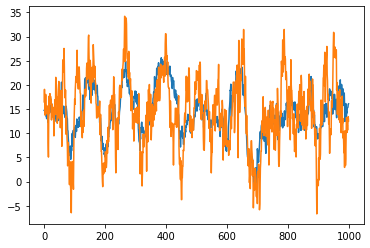

In [13]:
from sklearn import linear_model
from sklearn.metrics import r2_score

model = linear_model.LinearRegression()
model.fit(df0, dfs[0]["LT01"])

ym = model.predict(df0)
yv = dfs[0]["LT01"].values

plt.plot(ym)
plt.plot(yv)

print(r2_score(ym, yv))

In [14]:
def createModelMatrixForSingleInput(data, order, delay, exponent):
    if(order < 0 or delay < 0 or exponent <= 0):
        raise AssertionError("Invalid structure parameter")
        
    samples = data.shape[0]
    widthCoefficient = (order + 1)*exponent
    heightAbsoluteTerm = order + delay
    
    A = np.zeros([samples - heightAbsoluteTerm, widthCoefficient])
    
    for j in range(order+1):
        for k in range(exponent):
            colIndex = (order-j)*exponent + k
            A[:, colIndex] = np.power(data[j : samples-heightAbsoluteTerm+j], k+1)
    
    return A

In [15]:
df0 = df0.join(dfs[0]["LT01"])
df1 = df1.join(dfs[1]["LT01"])
df2 = df2.join(dfs[2]["LT01"])
df3 = df3.join(dfs[3]["LT01"])

In [16]:
def findMinDelayAndOrder(M):
    minDelay = 1000; minOrder = 1000
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order < minOrder):
            minOrder = order
        if(delay < minDelay):
            minDelay = delay
    
    return minDelay, minOrder

def findMaxDelayAndOrder(M):
    maxDelay = 0; maxOrder = 0
    for index, parameters in enumerate(M.T):
        order, delay, exponent = parameters
        if(order > maxOrder):
            maxOrder = order
        if(delay > maxDelay):
            maxDelay = delay
    
    return maxDelay, maxOrder

def prepareSignals(df, inputs, output, medfilt=False, kernelSize=11):
    inputSignals = df[inputs]
    outputSignal = df[output]
    inputFrame = pd.concat([inputSignals, outputSignal.shift(1)], axis=1).iloc[1:]

    if(medfilt == True):
        u_signals = applyMedianFilter(inputFrame.to_numpy(), kernelSize)
        y_signal = applyMedianFilter(df[output].iloc[1:].to_numpy(), kernelSize)

    else:
        u_signals = inputFrame.to_numpy()
        y_signal =  df[output].iloc[1:].to_numpy()
        
    return (u_signals, y_signal)

def createModelMatrix(data, M):
    if(M.shape[0] != 3):
        raise AssertionError("Invalid parameter vector size")

    if(M.shape[1] != data.shape[1]):
        raise AssertionError("Mismatched size of data: {} and M: {} vector".format(data.shape, M.shape))
        
    inputs = M.shape[1]
    height = data.shape[0]
    
    maxDelay, maxOrder = findMaxDelayAndOrder(M)
    minDelay, minOrder = findMinDelayAndOrder(M)
    A = np.empty(shape=(height-maxOrder-maxDelay, 0)) 
    for index, parameters in enumerate(M.T):
        # stworz macierz dla danego wejscia
        inputData = data[:, index]
        order, delay, exponent = parameters
        Ap = createModelMatrixForSingleInput(data[:, index], order, delay, exponent)
        
        # obetnij macierz - delay od góry, a order od dołu macierzy
        delayMaxDiff = np.abs(maxDelay-delay)
        orderMaxDiff = np.abs(maxOrder-order)
        baseHeight = Ap.shape[0]
        validA = Ap[orderMaxDiff+delayMaxDiff:]
        validA = validA[:A.shape[0]]
        
        # dodaj do akumulatora
        A = np.concatenate((A, validA), axis=1)
        
    return A

In [73]:
def evalModelScore(M, u_learn, y_learn, u_verif, y_verif):
    maxDelay, maxOrder = findMaxDelayAndOrder(M)   

    numberOfSamples = y_learn.shape[0]
    output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
    output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]
    
    A_learn = createModelMatrix(u_learn, M)
    model = linear_model.LinearRegression().fit(A_learn, output_learn_cut)
#     model = linear_model.Ridge(alpha=0.1).fit(A_learn, output_learn_cut)
   
    data_idx = maxOrder+maxDelay+1
    u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
    A_verif = createModelMatrix(u_verif_wip, M)
    
    model_outputs = np.array([])
    for i in range(data_idx, data_idx+len(output_learn_cut)):
        output_model_verif = model.predict(A_verif)
        model_outputs = np.append(model_outputs, output_model_verif)
        u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
        data_idx += 1
        u_verif_wip[-1][-1] = output_model_verif[-1]
        A_verif = createModelMatrix(u_verif_wip, M) 
        
    verif_score = r2_score(output_verif_cut, model_outputs)
    return model, verif_score

In [30]:
inputs = list(range(22))
output = ["LT01"]
u_learn, y_learn = prepareSignals(df0, inputs, output)
u_verif, y_verif = prepareSignals(df1, inputs, output)

In [33]:
def goalFunction(x):
    # zbuduj macierz M na podstawie wektora x
    M = np.empty(shape=(3, len(inputs) + 1), dtype=np.int32)
    for index, value in enumerate(x):
        row = index % 3; col = index // 3
        M[row, col] = int(value)
    
    model, score = evalModelScore(M, u_learn, y_learn, u_verif, y_verif)
    print(score)
    return (-1)*score

In [75]:
bounds = [(0, 10), (0,50), (1, 2)]*(len(inputs) + 1)
bounds[-2] = (1,1)
# result = differential_evolution(goalFunction, bounds, disp=True, polish=False, tol=1.0)

In [76]:

model, score = evalModelScore(M, u_learn, y_learn, u_verif, y_verif)
print(score)

-0.03634115765096646


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,LT01
0,-2.428805,2.518883,-0.248776,-2.236958,-2.836883,1.371784,2.299281,1.179536,-0.169418,-1.313724,...,0.201674,-0.034712,-0.179211,-0.134231,-0.285363,-0.082037,-0.296220,-0.973203,0.069395,8.0255
1,-2.429287,2.508340,-0.211119,-2.249929,-2.833570,1.378844,2.319447,1.152113,-0.154529,-1.310688,...,0.194673,-0.046294,-0.170620,-0.066289,-0.317487,-0.291788,-0.295620,-1.002239,0.054701,10.4238
2,-2.421074,2.436677,-0.247365,-2.180409,-2.728877,1.471329,2.372253,1.110862,-0.052842,-1.229960,...,0.238607,0.003451,-0.205498,-0.268869,-0.200967,0.370736,-0.275741,-0.757978,0.105304,12.7548
3,-2.534240,2.446244,-0.330390,-2.036740,-2.690038,1.537762,2.355066,1.121849,-0.003519,-1.447087,...,0.057657,-0.112970,-0.309975,-0.176325,-0.170677,0.363217,-0.189576,-0.552812,0.081245,11.6079
4,-2.440653,3.160518,0.073071,-2.312159,-2.784323,1.213127,2.398273,1.466710,-0.240877,-1.437273,...,0.168413,-0.408537,-0.403449,0.013857,-0.099230,-0.268555,0.744583,0.087664,0.396168,14.5283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-3.047736,2.208581,-1.111994,2.619657,-1.897004,3.024290,-0.924902,-1.310129,-0.575460,0.141189,...,0.347205,-0.485195,0.220576,-0.131637,0.005711,0.045708,-0.652879,0.196932,-0.170681,11.3588
995,-3.118614,2.145383,-1.061651,2.531584,-1.996341,2.999106,-0.913455,-1.444858,-0.684658,0.161611,...,0.488480,-0.295885,0.379189,-0.175505,-0.030742,-0.306804,-0.613682,0.127681,-0.136672,15.1249
996,-3.085768,2.084995,-1.104100,2.506580,-1.923136,3.046288,-0.815887,-1.483476,-0.636100,0.308176,...,0.553433,-0.206555,0.416751,-0.309687,0.021097,-0.219482,-0.603627,0.124516,-0.157819,14.0616
997,-3.127895,2.100759,-0.996791,2.485543,-2.032512,2.994630,-0.903899,-1.554290,-0.697223,0.151281,...,0.562043,-0.226210,0.474081,-0.140305,-0.095836,-0.716415,-0.564585,0.026121,-0.164137,12.9024


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
-0.03634115765096646


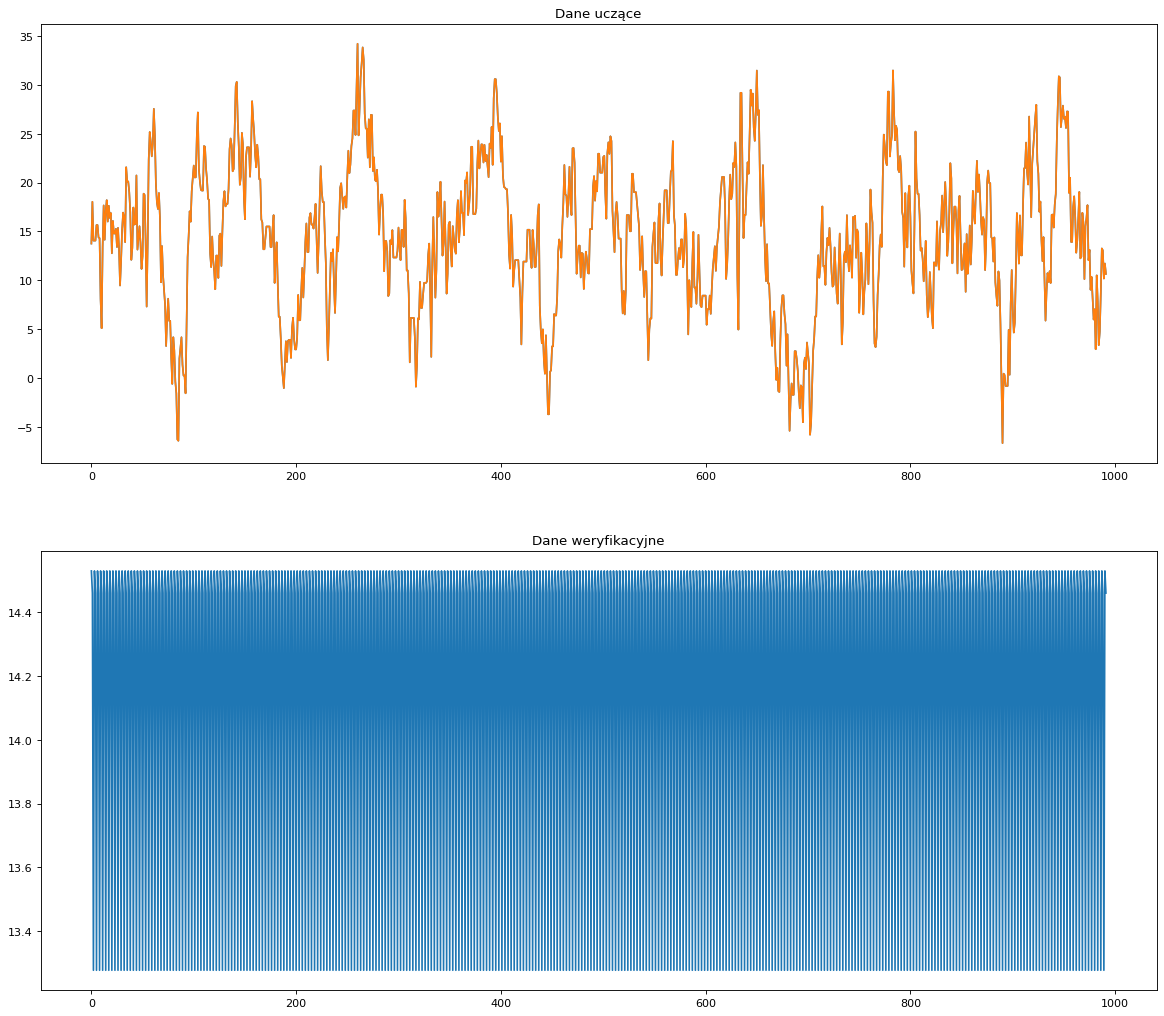

In [81]:
optimM = np.array([[3, 3, 3],[3, 3, 1],[3, 3, 1],[3, 3, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],
             [3, 3, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],[2, 2, 1],
             [2, 2, 1],[2, 2, 1],[2, 2, 1],[3, 3, 1],[2, 2, 1],[2, 2, 1],[2, 1, 1]]).transpose()

u_learn, y_learn = prepareSignals(df0, inputs, output)
u_verif, y_verif = prepareSignals(df1, inputs, output)
model, score = evalModelScore(optimM, u_learn, y_learn, u_verif, y_verif)

print(model)

maxDelay, maxOrder = findMaxDelayAndOrder(optimM)
numberOfSamples = y_learn.shape[0]
output_learn_cut = y_learn[maxDelay : numberOfSamples - maxOrder]
output_verif_cut = y_verif[maxDelay : numberOfSamples - maxOrder]

# A_verif = createModelMatrix(u_verif, optimM)
A_learn = createModelMatrix(u_learn, optimM)
y_model_learn = model.predict(A_learn)
# y_model_verif = model.predict(A_verif)

data_idx = maxOrder+maxDelay+1
u_verif_wip = np.array(u_verif[0:data_idx],copy=True)
A_verif = createModelMatrix(u_verif_wip, optimM)
    
model_outputs = np.array([])
for i in range(data_idx, data_idx+len(output_learn_cut)):
    output_model_verif = model.predict(A_verif)
    model_outputs = np.append(model_outputs, output_model_verif)
    u_verif_wip = np.vstack((u_verif_wip, u_verif[data_idx:data_idx+1]))[1:]
    data_idx += 1
    u_verif_wip[-1][-1] = output_model_verif[-1]
    A_verif = createModelMatrix(u_verif_wip, optimM) 
        
verif_score = r2_score(output_verif_cut, model_outputs)
print(verif_score)



# plot data
fig, axs = plt.subplots(2,figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axs[0].plot(output_learn_cut)
axs[0].plot(y_model_learn)
axs[0].set_title("Dane uczące")
# axs[1].plot(output_verif_cut)
axs[1].plot(model_outputs)
axs[1].set_title("Dane weryfikacyjne")
plt.rcParams['figure.figsize'] = [15, 20]